# Logistic Regression

In this lesson, we're going to implement logistic regression for a classification task where we want to probabilistically determine the outcome for a given set of inputs. We will understand the basic math behind it, implement it in just NumPy and then in TensorFlow + Keras.

<a href="https://github.com/madewithml/practicalAI/blob/master/notebooks/basic_ml/05_Logistic_Regression.ipynb" role="button"><img class="notebook-badge-image" src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/madewithml/practicalAI/blob/master/notebooks/basic_ml/05_Logistic_Regression.ipynb"><img class="notebook-badge-image" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

# Overview

Logistic regression is just an extension on linear regression (both are generalized linear methods). We will still learn to model a line (plane) that models $y$ given $X$. Except now we are dealing with classification problems as opposed to regression problems so we want classification probabilities. We'll be using the softmax operation to normalize our logits ($XW$) to derive probabilities.

Our goal is to learn a logistic model $\hat{y}$ that models $y$ given $X$. 

$ \hat{y} = \frac{e^{XW_y}}{\sum_j e^{XW}} $ 
* $\hat{y}$ = prediction | $\in \mathbb{R}^{NX1}$ ($N$ is the number of samples)
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W$ = weights | $\in \mathbb{R}^{DXC}$ ($C$ is the number of classes)

This function is known as the multinomial logistic regression or the softmax classifier. The softmax classifier will use the linear equation ($z=XW$) and normalize it (using the softmax function) to produce the probabiltiy for class y given the inputs.

**NOTE**: We'll leave the bias weights out for now to avoid complicating the backpropagation calculation.

* **Objective:**  Predict the probability of class $y$ given the inputs $X$. The softmax classifier normalizes the linear outputs to determine class probabilities. 
* **Advantages:**
  * Can predict class probabilities given a set on inputs.
* **Disadvantages:**
  * Sensitive to outliers since objective is to minimize cross entropy loss. Support vector machines ([SVMs](https://towardsdatascience.com/support-vector-machine-vs-logistic-regression-94cc2975433f)) are a good alternative to counter outliers.
* **Miscellaneous:** Softmax classifier is going to used widely in neural network architectures as the last layer since it produces class probabilities.

# Data

## Load data

We'll used some synthesized data to train our models on. The task is to determine whether a tumor will be benign (harmless) or malignant (harmful) based on leukocyte (white blood cells) count and blood pressure. Note that this is a synethic dataset that has no clinical relevance.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import urllib

In [0]:
SEED = 1234
DATA_FILE = 'tumors.csv'

In [0]:
# Set seed for reproducibility
np.random.seed(SEED)

In [0]:
# Download data from GitHub to this notebook's local drive
url = "https://raw.githubusercontent.com/madewithml/practicalAI/master/data/tumors.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)

In [0]:
# Read from CSV to Pandas DataFrame
df = pd.read_csv(DATA_FILE, header=0)
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,13.472969,15.250393,malignant
1,10.805510,14.109676,malignant
2,13.834053,15.793920,malignant
3,9.572811,17.873286,malignant
4,7.633667,16.598559,malignant


In [0]:
# Define X and y
X = df[['leukocyte_count', 'blood_pressure']].values
y = df['tumor_class'].values

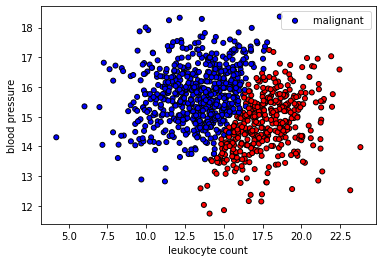

In [0]:
# Plot data
colors = {'benign': 'red', 'malignant': 'blue'}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors='k')
plt.xlabel('leukocyte count')
plt.ylabel('blood pressure')
plt.legend(['malignant ', 'benign'], loc="upper right")
plt.show()

## Split data

In [0]:
import collections
from sklearn.model_selection import train_test_split

In [0]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

Splitting the dataset for classification tasks requires more than just randomly splitting into train, validation and test sets. We want to ensure that each split has a similar class distribution so that we can learn to predict well across all the classes. We can do this by specifying the `stratify` argument in [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) which will be set to the class labels.

In [0]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, shuffle=shuffle) # notice the `stratify=y`
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle) # notice the `stratify=y_train`
    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")
print (f"Classes: {class_counts}")

X_train: (722, 2), y_train: (722,)
X_val: (128, 2), y_val: (128,)
X_test: (150, 2), y_test: (150,)
Sample point: [18.01865938 15.48133647] → benign
Classes: {'malignant': 611, 'benign': 389}


## Label encoder

You'll notice that our class labels are text. We need to encode them into integers so we can use them in our models. We're going to the scikit-learn's [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder) to do this. 

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
# Output vectorizer
y_tokenizer = LabelEncoder()

In [0]:
# Fit on train data
y_tokenizer = y_tokenizer.fit(y_train)
classes = y_tokenizer.classes_
print (f"classes: {classes}")

classes: ['benign' 'malignant']


In [0]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: benign
y_train[0]: 0


In [0]:
# Class weights
counts = collections.Counter(y_train)
class_weights = {_class: 1.0/count for _class, count in counts.items()}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: Counter({1: 441, 0: 281}),
class weights: {0: 0.0035587188612099642, 1: 0.0022675736961451248}


**NOTE**: Class weights are useful for weighting the loss function during training. It tells the model to focus on samples from an under-represented class. The loss section below will show how to incorporate these weights.

## Standardize data

We need to standardize our data (zero mean and unit variance) in order to optimize quickly. We're only going to standardize the inputs X because our outputs y are class values.

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [0]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [0]:
# Check (means should be ~0 and std should be ~1)
print (f"X_train[0]: mean: {np.mean(X_train[:, 0], axis=0):.1f}, std: {np.std(X_train[:, 0], axis=0):.1f}")
print (f"X_train[1]: mean: {np.mean(X_train[:, 1], axis=0):.1f}, std: {np.std(X_train[:, 1], axis=0):.1f}")
print (f"X_val[0]: mean: {np.mean(X_val[:, 0], axis=0):.1f}, std: {np.std(X_val[:, 0], axis=0):.1f}")
print (f"X_val[1]: mean: {np.mean(X_val[:, 1], axis=0):.1f}, std: {np.std(X_val[:, 1], axis=0):.1f}")
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_train[0]: mean: 0.0, std: 1.0
X_train[1]: mean: -0.0, std: 1.0
X_val[0]: mean: 0.1, std: 1.0
X_val[1]: mean: 0.1, std: 1.0
X_test[0]: mean: -0.1, std: 1.0
X_test[1]: mean: -0.1, std: 1.0


# NumPy

Now that we have our data prepared, we'll first implement logistic regression using just NumPy. This will let us really understand the underlying operations. It's normal to find the math and code in this section slightly complex. You can still read each of the steps to build intuition for when we implement this using TensorFlow + Keras.

Our goal is to learn a logistic model $\hat{y}$ that models $y$ given $X$. 

$ \hat{y} = \frac{e^{XW_y}}{\sum e^{XW}} $ 
* $\hat{y}$ = prediction | $\in \mathbb{R}^{NX1}$ ($N$ is the number of samples)
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W$ = weights | $\in \mathbb{R}^{DXC}$ ($C$ is the number of classes)

We are going to use multinomial logistic regression even though our task only involves two classes because you can generalize the softmax classifier to any number of classes.

## Initialize weights

1. Randomly initialize the model's weights $W$.

In [0]:
INPUT_DIM = X_train.shape[1] # X is 2-dimensional
NUM_CLASSES = len(classes) # y has two possibilities (begign or malignant)

In [0]:
# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))
print (f"W: {W.shape}")
print (f"b: {b.shape}")

W: (2, 2)
b: (1, 2)


## Model

2. Feed inputs $X$ into the model to receive the logits ($z=XW$). Apply the softmax operation on the logits to get the class probabilies $\hat{y}$ in one-hot encoded form. For example, if there are three classes, the predicted class probabilities could look like [0.3, 0.3, 0.4]. 
  * $ \hat{y} = softmax(z) = softmax(XW) = \frac{e^{XW_y}}{\sum_j e^{XW}} $

In [0]:
# Forward pass [NX2] · [2X2] + [1,2] = [NX2]
logits = np.dot(X_train, W) + b
print (f"logits: {logits.shape}")
print (f"sample: {logits[0]}")

logits: (722, 2)
sample: [0.01817675 0.00635562]


In [0]:
# Normalization via softmax to obtain class probabilities
exp_logits = np.exp(logits)
y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")

y_hat: (722, 2)
sample: [0.50295525 0.49704475]


## Loss

 3. Compare the predictions $\hat{y}$ (ex.  [0.3, 0.3, 0.4]]) with the actual target values $y$ (ex. class 2 would look like [0, 0, 1]) with the objective (cost) function to determine loss $J$. A common objective function for logistics regression is cross-entropy loss. 

  * $J(\theta) = - \sum_i ln(\hat{y_i}) = - \sum_i ln (\frac{e^{X_iW_y}}{\sum_j e^{X_iW}}) $

In [0]:
# Loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
loss = np.sum(correct_class_logprobs) / len(y_train)
print (f"loss: {loss:.2f}")

loss: 0.69


## Gradients

4. Calculate the gradient of loss $J(\theta)$ w.r.t to the model weights. Let's assume that our classes are mutually exclusive (a set of inputs could only belong to one class).
 * $\frac{\partial{J}}{\partial{W_j}} = \frac{\partial{J}}{\partial{\hat{y}}}\frac{\partial{\hat{y}}}{\partial{W_j}} = - \frac{1}{\hat{y}}\frac{\partial{\hat{y}}}{\partial{W_j}} = - \frac{1}{\frac{e^{XW_y}}{\sum_j e^{XW}}}\frac{\sum_j e^{XW}e^{XW_y}0 - e^{XW_y}e^{XW_j}X}{(\sum_j e^{XW})^2} = \frac{Xe^{XW_j}}{\sum_j e^{XW}} = X\hat{y}$
  * $\frac{\partial{J}}{\partial{W_y}} = \frac{\partial{J}}{\partial{\hat{y}}}\frac{\partial{\hat{y}}}{\partial{W_y}} = - \frac{1}{\hat{y}}\frac{\partial{\hat{y}}}{\partial{W_y}} = - \frac{1}{\frac{e^{XW_y}}{\sum_j e^{XW}}}\frac{\sum_j e^{XW}e^{XW_y}X - e^{W_yX}e^{XW_y}X}{(\sum_j e^{XW})^2} = \frac{1}{\hat{y}}(X\hat{y} - X\hat{y}^2) = X(\hat{y}-1)$

In [0]:
# Backpropagation
dscores = y_hat
dscores[range(len(y_hat)), y_train] -= 1
dscores /= len(y_train)
dW = np.dot(X_train.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)

## Update weights

5. Update the weights  𝑊  using a small learning rate  𝛼. The updates willpenalize the probabiltiy for the incorrect classes (j) and encourage a higher probability for the correct class (y).
  * $W_j = W_j - \alpha\frac{\partial{J}}{\partial{W_j}}$

In [0]:
LEARNING_RATE = 1e-1

In [0]:
# Update weights
W += -LEARNING_RATE * dW
b += -LEARNING_RATE * db

## Training

In [0]:
NUM_EPOCHS = 100

6. Repeat steps 2 - 5 to minimize the loss and train the model.

In [0]:
# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))

# Training loop
for epoch_num in range(NUM_EPOCHS):

    # Forward pass [NX2] · [2X2] = [NX2]
    logits = np.dot(X_train, W) + b
    
    # Normalization via softmax to obtain class probabilities
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Loss
    correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
    loss = np.sum(correct_class_logprobs) / len(y_train)

    # show progress
    if epoch_num%10 == 0:
        # Accuracy
        y_pred = np.argmax(logits, axis=1)
        accuracy =  np.mean(np.equal(y_train, y_pred))
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

    # Backpropagation
    dscores = y_hat
    dscores[range(len(y_hat)), y_train] -= 1
    dscores /= len(y_train)
    dW = np.dot(X_train.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    # Update weights
    W += -LEARNING_RATE * dW
    b += -LEARNING_RATE * db

Epoch: 0, loss: 0.684, accuracy: 0.889
Epoch: 10, loss: 0.447, accuracy: 0.978
Epoch: 20, loss: 0.348, accuracy: 0.978
Epoch: 30, loss: 0.295, accuracy: 0.981
Epoch: 40, loss: 0.260, accuracy: 0.981
Epoch: 50, loss: 0.236, accuracy: 0.981
Epoch: 60, loss: 0.217, accuracy: 0.981
Epoch: 70, loss: 0.203, accuracy: 0.981
Epoch: 80, loss: 0.191, accuracy: 0.981
Epoch: 90, loss: 0.181, accuracy: 0.981


Since we're taking the argmax, we can just calculate logits since normalization won't change which index has the higher value. 

In [0]:
class LogisticRegressionFromScratch():
    def predict(self, x):
        logits = np.dot(x, W) + b
        exp_logits = np.exp(logits)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return y_hat

In [0]:
# Evaluation
model = LogisticRegressionFromScratch()
logits_train = model.predict(X_train)
pred_train = np.argmax(logits_train, axis=1)
logits_test = model.predict(X_test)
pred_test = np.argmax(logits_test, axis=1)

In [0]:
# Training and test accuracy
train_acc =  np.mean(np.equal(y_train, pred_train))
test_acc = np.mean(np.equal(y_test, pred_test))
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.98, test acc: 0.95


In [0]:
def plot_multiclass_decision_boundary(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot
    if savefig_fp:
        plt.savefig(savefig_fp, format='png')

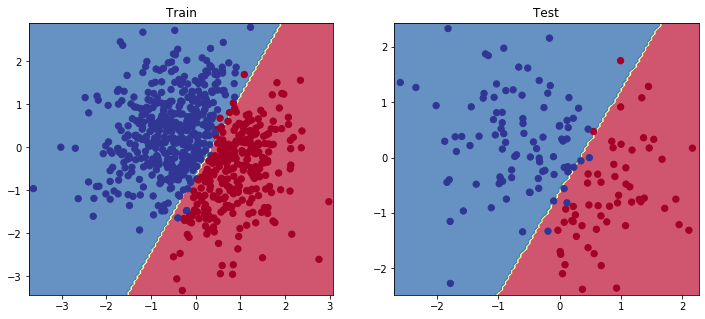

In [0]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

Credit for the plotting functions and the intuition behind all this is due to [CS231n](http://cs231n.github.io/neural-networks-case-study/), one of the best courses for machine learning. Now let's implement logistic regression with TensorFlow + Keras.

# TensorFlow + Keras

Now that we've implemented logistic regression with Numpy, let's do the same with TensorFlow + Keras. 

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# Set seed for reproducibility
tf.random.set_seed(SEED)

## Model

We will be using [Dense](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dense) layers to recreate the same model and use [SparseCategoricalCrossentropy](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as our loss function.

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [0]:
class LogisticRegression(Model):
    def __init__(self, num_classes):
        super(LogisticRegression, self).__init__(name='logistic_regression')
        self.fc1 = Dense(units=num_classes, activation='softmax', name='W')
        
    def call(self, x_in, training=False):
        y_pred = self.fc1(x_in)
        return y_pred
    
    def summary(self, input_shape):
        x_in = Input(shape=input_shape, name='X')
        summary = Model(inputs=x_in, outputs=self.call(x_in), name=self.name)
        summary.summary() # parameter summary
        print ("\n\nWEIGHTS:") # weights summary
        for layer in self.layers:
            print ("_"*50)
            print (layer.name)
            for w in layer.weights:
                print (f"\t{w.name} → {w.shape}")
        print ("\n\nFORWARD PASS:")
        return plot_model(summary, show_shapes=True) # forward pass

In [0]:
# Initialize model
model = LogisticRegression(num_classes=NUM_CLASSES)

Model: "logistic_regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 2)]               0         
_________________________________________________________________
W (Dense)                    (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


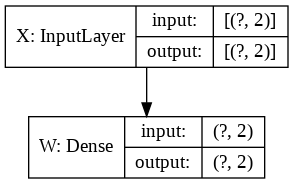

In [0]:
# Summary
model.summary(input_shape=(INPUT_DIM,))

## Optimizer

In [0]:
from tensorflow.keras.optimizers import Adam

In [0]:
optimizer=Adam(lr=LEARNING_RATE)

## Loss

Our loss will be the sparse categorical crossentropy. 

In [0]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [0]:
scce = tf.keras.losses.SparseCategoricalCrossentropy()
ground_truth = tf.convert_to_tensor([0, 1, 2])
probabilities = tf.convert_to_tensor([[.9, .05, .05], [.5, .89, .6], [.05, .01, .94]])
loss = scce(ground_truth, probabilities)
print (loss.numpy())

0.32396814


## Metrics

In [0]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [0]:
m = SparseCategoricalAccuracy()
m.update_state(ground_truth, probabilities)
print( m.result().numpy()) 

1.0


## Training

In [0]:
BATCH_SIZE = 32

In [0]:
# Compile
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [0]:
# Training
model.fit(x=X_train, 
          y=y_train,
          validation_data=(X_val, y_val),
          epochs=NUM_EPOCHS,
          batch_size=BATCH_SIZE,
          class_weight=class_weights, 
          shuffle=False,
          verbose=1)

**NOTE**: We used the `class_weights` from earlier which will be used with our loss function to account for any class imbalances (our dataset doesn't suffer from this issue).

## Evaluation

In [0]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """Plot a confusion matrix using ground truth and predictions."""
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #  Figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Axis
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    ax.set_xticklabels([''] + classes)
    ax.set_yticklabels([''] + classes)
    ax.xaxis.set_label_position('bottom') 
    ax.xaxis.tick_bottom()

    # Values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:d} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Display
    plt.show()

In [0]:
# Predictions
pred_train = model.predict(X_train) 
pred_test = model.predict(X_test)
print (f"sample probability: {pred_test[0]}")
pred_train = np.argmax(pred_train, axis=1)
pred_test = np.argmax(pred_test, axis=1)
print (f"sample class: {pred_test[0]}")

sample probability: [4.9913465e-06 9.9999499e-01]
sample class: 1


In [0]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.99, test acc: 0.98


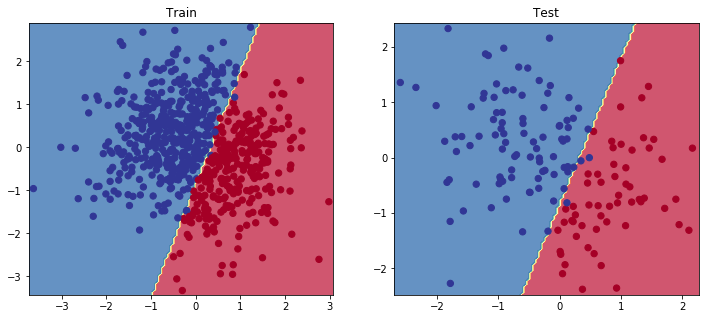

In [0]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

So far we looked at accuracy as the metric that determines our mode's level of performance. But we have several other options when it comes to  evaluation metrics.

<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/05_Logistic_Regression/metrics.png" width="350">

<small>Image credit: "Precisionrecall" by Walber</small>

The metric we choose really depends on the situation.
positive - true, 1, tumor, issue, etc., negative - false, 0, not tumor, not issue, etc.

$\text{accuracy} = \frac{TP+TN}{TP+TN+FP+FN}$ 

$\text{recall} = \frac{TP}{TP+FN}$ → (how many of the actual issues did I catch)

$\text{precision} = \frac{TP}{TP+FP}$ → (out of all the things I said were issues, how many were actually issues)

$F_1 = 2 * \frac{\text{precision }  *  \text{ recall}}{\text{precision } + \text{ recall}}$

where: 
* TP: # of samples predicted to be positive and were actually positive
* TN: # of samples predicted to be negative and were actually negative
* FP: # of samples predicted to be positive but were actually negative
* FN: # of samples predicted to be negative but were actually positive

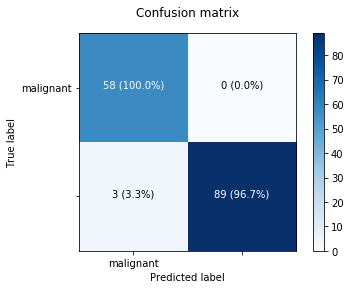

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        58
           1       1.00      0.97      0.98        92

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



In [0]:
# Classification report
plot_confusion_matrix(y_true=y_test, y_pred=pred_test, classes=classes)
print (classification_report(y_test, pred_test))

## Inference

In [0]:
# Inputs for inference
X_infer = pd.DataFrame([{'leukocyte_count': 13, 'blood_pressure': 12}])
X_infer.head()

,leukocyte_count,blood_pressure
0,13,12


In [0]:
# Standardize
X_infer = X_scaler.transform(X_infer)
print (X_infer)

[[-0.66523095 -3.08638693]]


In [0]:
# Predict
y_infer = model.predict(X_infer)
_class = np.argmax(y_infer)
print (f"The probability that you have a {classes[_class]} tumor is {y_infer[0][_class]*100.0:.0f}%")

The probability that you have a benign tumor is 99%


# Unscaled weights

Note that only X was standardized.

$\hat{y}_{unscaled} = b_{scaled} + \sum_{j=1}^{k}W_{{scaled}_j}x_{{scaled}_j}$
* $x_{scaled} = \frac{x_j - \bar{x}_j}{\sigma_j}$

$\hat{y}_{unscaled} = b_{scaled} + \sum_{j=1}^{k} W_{{scaled}_j} (\frac{x_j - \bar{x}_j}{\sigma_j}) $

$\hat{y}_{unscaled} = (b_{scaled} - \sum_{j=1}^{k} W_{{scaled}_j}\frac{\bar{x}_j}{\sigma_j}) +  \sum_{j=1}^{k} (\frac{W_{{scaled}_j}}{\sigma_j})x_j$

In the expression above, we can see the expression $\hat{y}_{unscaled} = W_{unscaled}x + b_{unscaled} $

* $W_{unscaled} = \sum_{j=1}^{k} (\frac{W_{{scaled}_j}}{\sigma_j}) $

* $b_{unscaled} = b_{scaled} - \sum_{j=1}^{k} W_{{scaled}_j}\frac{\bar{x}_j}{\sigma_j}$

In [0]:
# Unstandardize weights 
W = model.layers[1].get_weights()[0]
b = model.layers[1].get_weights()[1]
W_unscaled = W / X_scaler.scale_
b_unscaled = b - np.sum((W_unscaled * X_scaler.mean_))
print (W_unscaled)
print (b_unscaled)

[[  4.3011528  -13.07971476]
 [ -1.81267395   4.48274612]]
[90.372795 98.9687  ]


---
Share and discover ML projects at <a href="https://madewithml.com/#newsletter">Made With ML</a>.

<a class="ai-header-badge" target="_blank" href="https://github.com/practicalAI/practicalAI"><img src="https://img.shields.io/github/stars/practicalAI/practicalAI.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
             